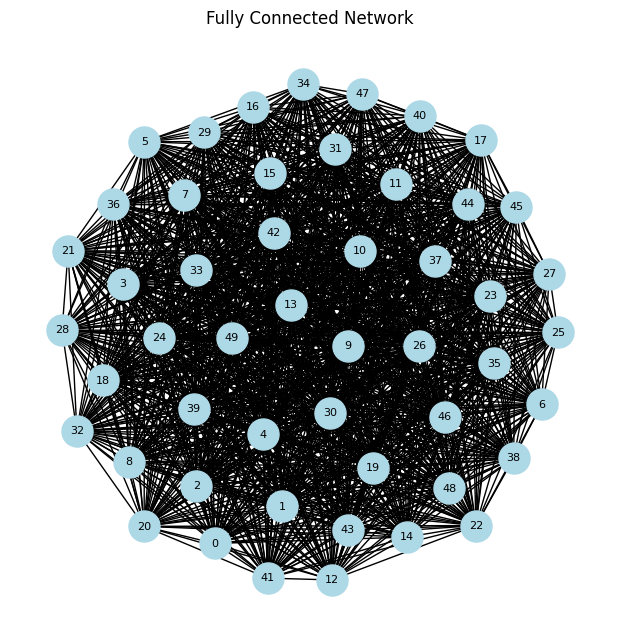

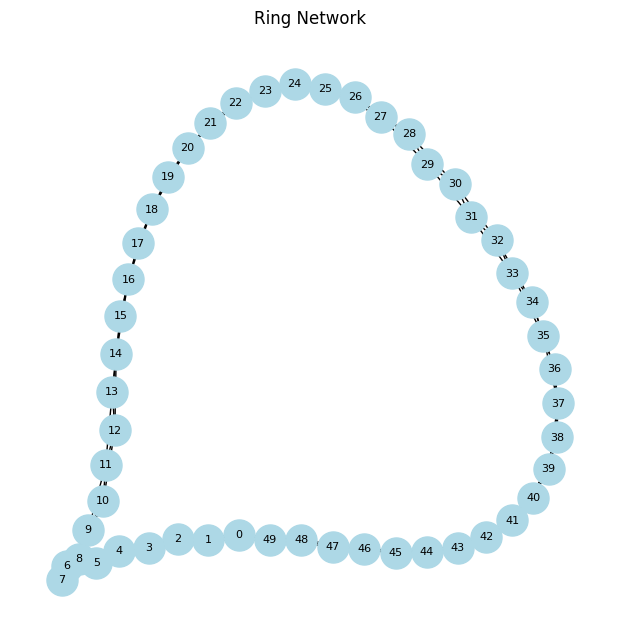

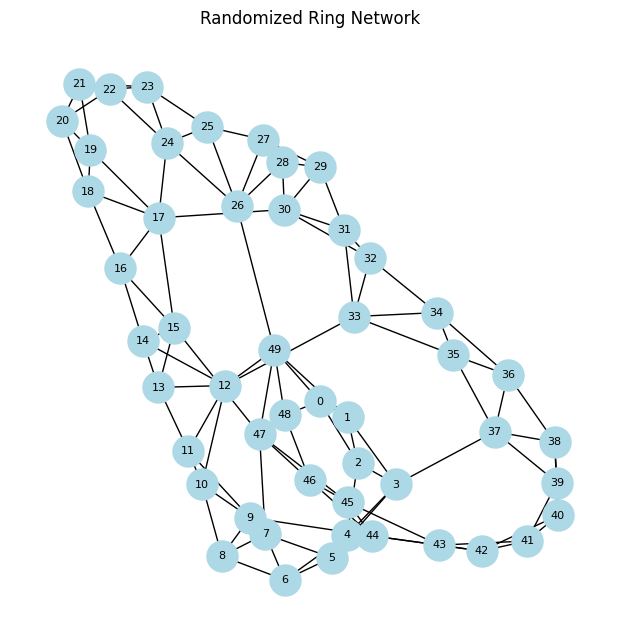

Running for Fully Connected...


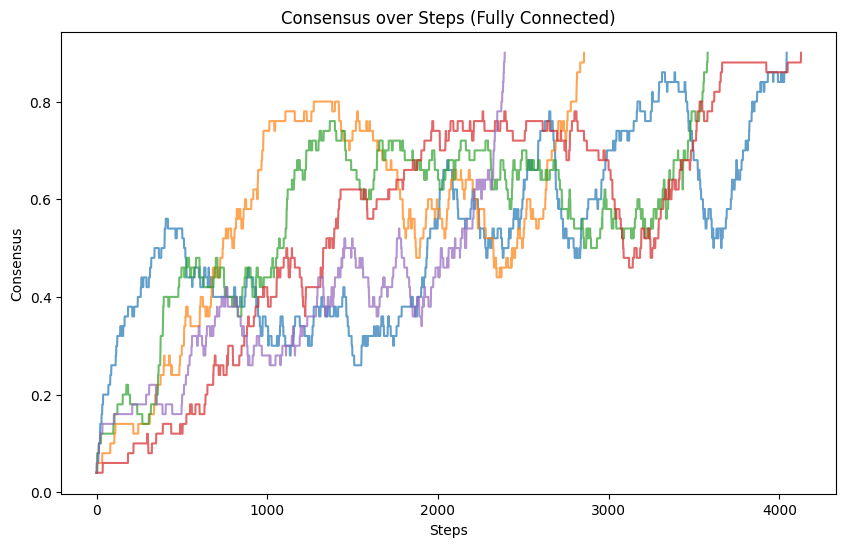

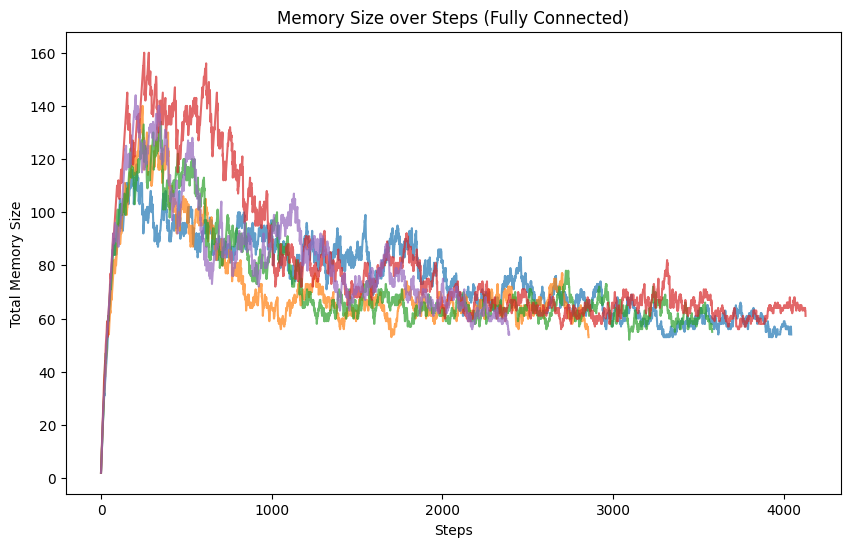

Running for Ring Network...


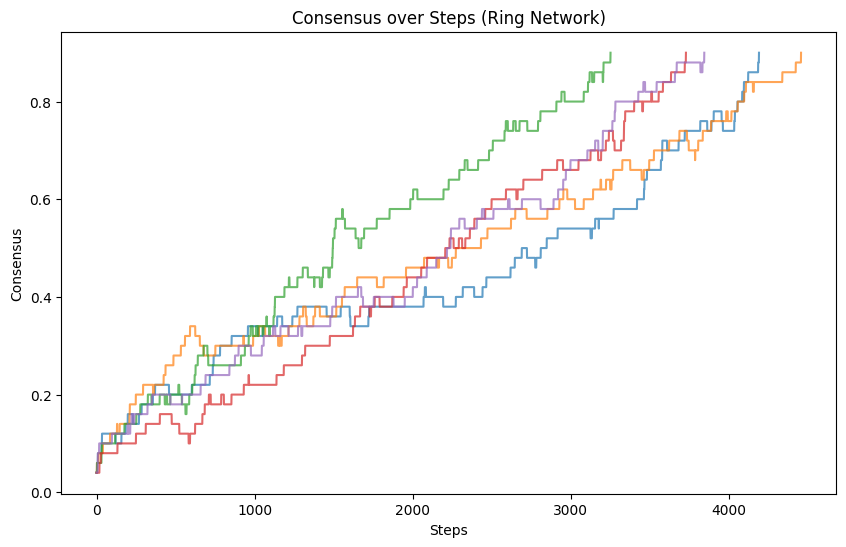

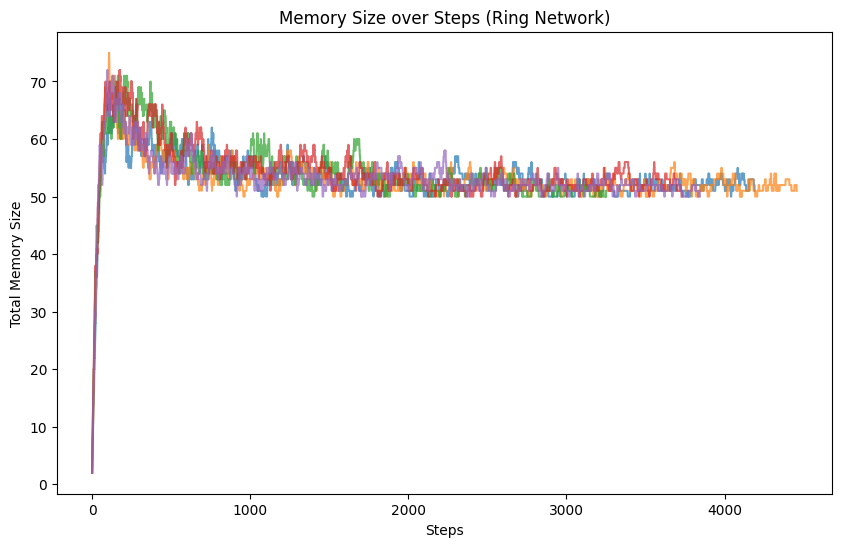

Running for Randomized Ring Network...


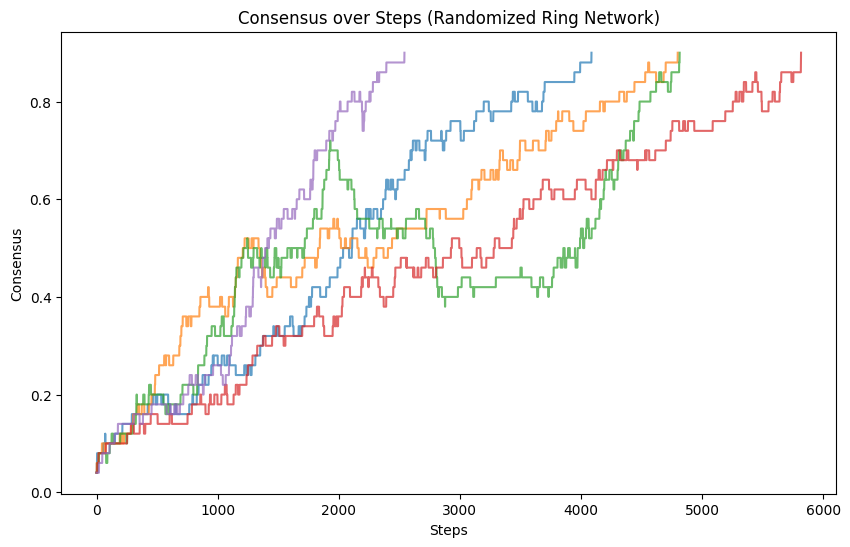

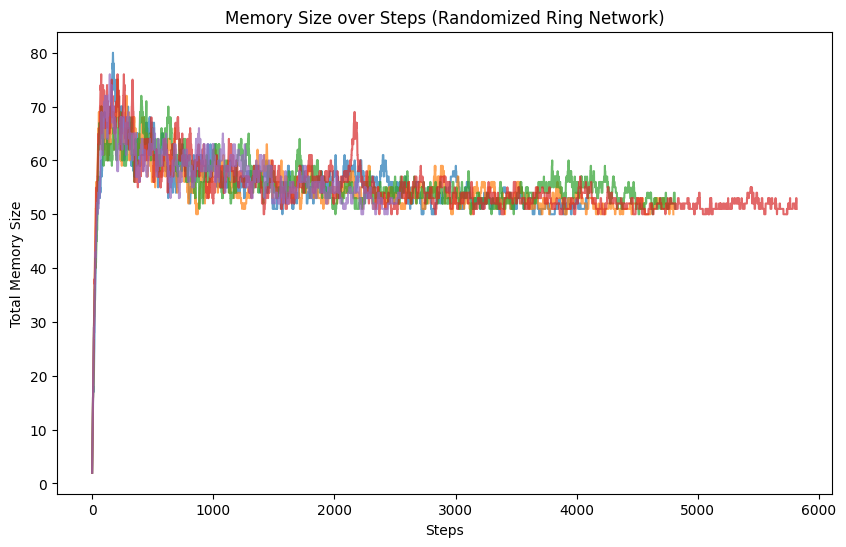

In [13]:
import networkx as nx
import random
import matplotlib.pyplot as plt
from collections import Counter

# --- STEP 1: Network Creation Functions ---
# 1. Fully connected network
def create_fully_connected_network(n):
    return nx.complete_graph(n)

# 2. Ring network with neighborhood size 2
def create_ring_network(n):
    G = nx.Graph()
    for i in range(n):
        for j in range(1, 3):  # Neighborhood size 2
            G.add_edge(i, (i + j) % n)
            G.add_edge(i, (i - j) % n)
    return G

# 3. Ring network with 10 random connections
def create_randomized_ring_network(n, extra_edges=10):
    G = create_ring_network(n)
    nodes = list(G.nodes())
    for _ in range(extra_edges):
        u, v = random.sample(nodes, 2)
        G.add_edge(u, v)
    return G

# Visualize networks
def plot_network(G, title):
    plt.figure(figsize=(6, 6))
    pos = nx.spring_layout(G, seed=42)  # Consistent layout
    nx.draw(G, pos, with_labels=True, node_size=500, node_color="lightblue", font_size=8)
    plt.title(title)
    plt.show()

# Create and plot networks
n = 50
fully_connected = create_fully_connected_network(n)
ring_network = create_ring_network(n)
randomized_ring = create_randomized_ring_network(n)

plot_network(fully_connected, "Fully Connected Network")
plot_network(ring_network, "Ring Network")
plot_network(randomized_ring, "Randomized Ring Network")

# --- STEP 2: Naming Game Simulation ---
# Initialize agents with empty memory
def initialize_agents(n):
    return {i: [] for i in range(n)}

# Generate a new unique name
def generate_new_name(used_names):
    new_name = f"Name_{len(used_names)}"
    used_names.add(new_name)
    return new_name

# Naming game interaction
def naming_game_step(agents, G, used_names):
    speaker, hearer = random.sample(list(G.edges()), 1)[0]  # Select random edge
    speaker_memory = agents[speaker]
    hearer_memory = agents[hearer]

    if not speaker_memory:  # Speaker creates a new name
        name = generate_new_name(used_names)
        speaker_memory.append(name)
    else:
        name = speaker_memory[0]  # Speaker uses the first name

    if name in hearer_memory:  # Success
        agents[speaker] = [name]  # Both agents retain only the successful name
        agents[hearer] = [name]
    else:  # Failure
        hearer_memory.append(name)
        if len(hearer_memory) > 10:  # Maintain memory capacity
            hearer_memory.pop(0)

# Measure consensus
def calculate_consensus(agents):
    all_names = [name for memory in agents.values() for name in memory[:1]]
    if not all_names:
        return 0
    most_common_name, count = Counter(all_names).most_common(1)[0]
    return count / len(agents)

# Run simulation
def simulate_naming_game(G, max_steps=10**6):
    agents = initialize_agents(len(G))
    used_names = set()
    consensus = 0
    step = 0

    consensus_steps = []
    memory_sizes = []

    while consensus < 0.9 and step < max_steps:
        naming_game_step(agents, G, used_names)
        consensus = calculate_consensus(agents)
        total_memory_size = sum(len(memory) for memory in agents.values())

        consensus_steps.append((step, consensus))
        memory_sizes.append((step, total_memory_size))

        step += 1

    return consensus_steps, memory_sizes

# --- STEP 3: Run and Plot Results ---
# Plot results
def plot_results(results, title, ylabel):
    plt.figure(figsize=(10, 6))
    for res in results:
        steps, values = zip(*res)
        plt.plot(steps, values, alpha=0.7)
    plt.title(title)
    plt.xlabel("Steps")
    plt.ylabel(ylabel)
    plt.show()

# Run simulation for each network
def run_experiment():
    networks = [
        ("Fully Connected", fully_connected),
        ("Ring Network", ring_network),
        ("Randomized Ring Network", randomized_ring),
    ]
    all_results = {}

    for name, network in networks:
        print(f"Running for {name}...")
        results_consensus = []
        results_memory = []
        for _ in range(5):  # Five runs per network
            consensus_steps, memory_sizes = simulate_naming_game(network)
            results_consensus.append(consensus_steps)
            results_memory.append(memory_sizes)

        all_results[name] = (results_consensus, results_memory)
        plot_results(results_consensus, f"Consensus over Steps ({name})", "Consensus")
        plot_results(results_memory, f"Memory Size over Steps ({name})", "Total Memory Size")

    return all_results

# Execute the experiment
experiment_results = run_experiment()
